# Heritability Analysis

This note demonstrates the workflow for a typical heritability analysis in genetics, using a sample data set `cg10k` with **6,670** individuals and **630,860** SNPs. Person IDs and phenotype names are masked for privacy. Here `cg10k.bed`, `cg10k.bim`, and `cg10k.fam` is a set of Plink files in binary format. `cg10k_traits.txt` contains the phenotype data of 6,670 individuals.

In [1]:
;ls cg10k*.*

cg10k.bed
cg10k.bim
cg10k.fam
cg10k.ipynb
cg10k.jld
cg10k_traits.txt


Machine information:

In [2]:
versioninfo()

Julia Version 0.4.6
Commit 2e358ce (2016-06-19 17:16 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


## Read in binary SNP data

We will use the [`SnpArrays`](https://github.com/Hua-Zhou/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue `Pkg.clone("git@github.com:Hua-Zhou/SnpArrays.jl.git")` within `Julia` to install the `SnpArrays` package.

In [3]:
#Pkg.clone("git@github.com:Hua-Zhou/SnpArrays.jl.git")
using SnpArrays

In [4]:
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time cg10k = SnpArray("cg10k")

 32.347791 seconds (501.68 k allocations: 1.003 GB, 0.03% gc time)


6670x630860 SnpArrays.SnpArray{2}:
 (false,true)   (false,true)   (true,true)   …  (true,true)    (true,true) 
 (true,true)    (true,true)    (false,true)     (false,true)   (true,false)
 (true,true)    (true,true)    (false,true)     (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (false,true)   (true,true) 
 (true,true)    (true,true)    (true,true)      (true,true)    (false,true)
 (false,true)   (false,true)   (true,true)   …  (true,true)    (true,true) 
 (false,false)  (false,false)  (true,true)      (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (true,true)    (false,true)
 (true,true)    (true,true)    (false,true)     (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (false,true)   (true,true) 
 (true,true)    (true,true)    (false,true)  …  (true,true)    (true,true) 
 (false,true)   (false,true)   (true,true)      (true,true)    (false,true)
 (true,true)    (true,true)    (true,true)      (true

## Summary statistics of SNP data

In [5]:
people, snps = size(cg10k)

(6670,630860)

In [6]:
# summary statistics (~50 secs on my laptop)
@time maf, minor_allele, missings_by_snp, missings_by_person = summarize(cg10k)

 32.476006 seconds (42.38 k allocations: 11.660 MB, 0.01% gc time)


([0.169916,0.17099,0.114026,0.268694,0.219265,0.23935,0.190612,0.20201,0.0271609,0.299714  …  0.207996,0.448012,0.295465,0.142654,0.170915,0.281428,0.0611354,0.0524738,0.13931,0.132413],Bool[true,true,true,true,true,true,true,true,true,true  …  true,true,true,true,true,true,true,true,true,true],[2,0,132,77,0,27,2,2,6,27  …  4,5,11,0,0,4,29,0,5,43],[364,1087,1846,1724,1540,248,215,273,273,224  …  1353,692,901,1039,685,304,223,1578,2059,1029])

In [7]:
# 5 number summary and average MAF (minor allele frequencies)
quantile(maf, [0.0 .25 .5 .75 1.0]), mean(maf)

(
1x5 Array{Float64,2}:
 0.00841726  0.124063  0.236953  0.364253  0.5,

0.24536516625042462)


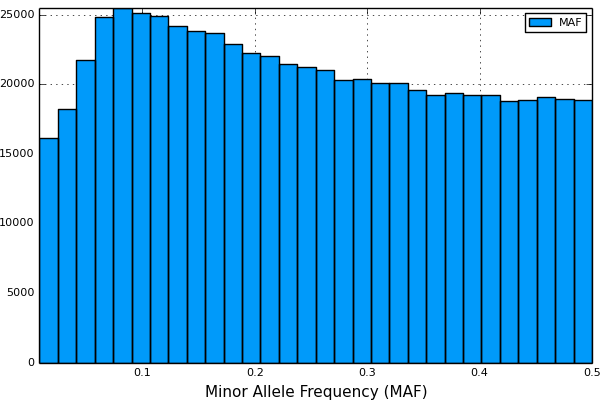

In [32]:
using Plots
pyplot()
#gr()

histogram(maf, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [9]:
# proportion of missing genotypes
sum(missings_by_snp) / length(cg10k)

0.0013128198764010824

In [10]:
# proportion of rare SNPs with maf < 0.05
countnz(maf .< 0.05) / length(maf)

0.07228069619249913

## Empirical kinship matrix

We estimate empirical kinship based on all SNPs by the genetic relation matrix (GRM). Missing genotypes are imputed on the fly by drawing according to the minor allele frequencies.

In [11]:
# GRM using all SNPs (~10 mins on my laptop)
srand(123)
@time Φgrm = grm(cg10k; method = :GRM)

314.952653 seconds (4.21 G allocations: 64.484 GB, 1.56% gc time)


6670x6670 Array{Float64,2}:
  0.502916      0.00329978   -0.000116213  …  -6.46286e-5   -0.00281229 
  0.00329978    0.49892      -0.00201992       0.000909871   0.00345573 
 -0.000116213  -0.00201992    0.493632         0.000294565  -0.000349854
  0.000933977  -0.00320391   -0.0018611       -0.00241682   -0.00127078 
 -7.75429e-5   -0.0036075     0.00181442       0.00213976   -0.00158382 
  0.00200371    0.000577386   0.0025455    …   0.000943753  -1.82994e-6 
  0.000558503   0.00241421   -0.0018782        0.001217     -0.00123924 
 -0.000659495   0.00319987   -0.00101496       0.00353646   -0.00024093 
 -0.00102619   -0.00120448   -0.00055462       0.00175586    0.00181899 
 -0.00136838    0.00211996    0.000119128     -0.00147305   -0.00105239 
 -0.00206144    0.000148818  -0.000475177  …  -0.000265522  -0.00106123 
  0.000951016   0.00167042    0.00183545      -0.000703658  -0.00313334 
  0.000330442  -0.000904147   0.00301478       0.000754772  -0.00127413 
  ⋮                    

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [12]:
using DataFrames

cg10k_trait = readtable("cg10k_traits.txt"; 
    separator = ' ',
    names = [:FID; :IID; :Trait1; :Trait2; :Trait3; :Trait4; :Trait5; :Trait6; 
             :Trait7; :Trait8; :Trait9; :Trait10; :Trait11; :Trait12; :Trait13],  
    eltypes = [UTF8String; UTF8String; Float64; Float64; Float64; Float64; Float64; 
               Float64; Float64; Float64; Float64; Float64; Float64; Float64; Float64])

,FID,IID,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10,Trait11,Trait12,Trait13
1,10002K,10002K,-1.81573145026234,-0.94615046147283,1.11363077580442,-2.09867121119159,0.744416614111748,0.00139171884080131,0.934732480409667,-1.22677315418103,1.1160784277875,-0.4436280335029,0.824465656443384,-1.02852542216546,-0.394049201727681
2,10004O,10004O,-1.24440094378729,0.109659992547179,0.467119394241789,-1.62131304097589,1.0566758355683,0.978946979419181,1.00014633946047,0.32487427140228,1.16232175219696,2.6922706948705,3.08263672461047,1.09064954786013,0.0256616415357438
3,10005Q,10005Q,1.45566914502305,1.53866932923243,1.09402959376555,0.586655272226893,-0.32796454430367,-0.30337709778827,-0.0334354881314741,-0.464463064285437,-0.3319396273436,-0.486839089635991,-1.10648681564373,-1.42015780427231,-0.687463456644413
4,10006S,10006S,-0.768809276698548,0.513490885514249,0.244263028382142,-1.31740254475691,1.19393774326845,1.17344127734288,1.08737426675232,0.536022583732261,0.802759240762068,0.234159411749815,0.394174866891074,-0.767365892476029,0.0635385761884935
5,10009Y,10009Y,-0.264415132547719,-0.348240421825694,-0.0239065083413606,0.00473915802244948,1.25619191712193,1.2038883667631,1.29800739042627,0.310113660247311,0.626159861059352,0.899289129831224,0.54996783350812,0.540687809542048,0.179675416046033
6,10010J,10010J,-1.37617270917293,-1.47191967744564,0.291179894254146,-0.803110740704731,-0.264239977442213,-0.260573027836772,-0.165372266287781,-0.219257294118362,1.04702422290318,-0.0985815534616482,0.947393438068448,0.594014812031438,0.245407436348479
7,10011L,10011L,0.1009416296374,-0.191615722103455,-0.567421321596677,0.378571487240382,-0.246656179817904,-0.608810750053858,0.189081058215596,-1.27077787326519,-0.452476199143965,0.702562877297724,0.332636218957179,0.0026916503626181,0.317117176705358
8,10013P,10013P,-0.319818276367464,1.35774480657283,0.818689545938528,-1.15565531644352,0.63448368102259,0.291461908634679,0.933323714954726,-0.741083289682492,0.647477683507572,-0.970877627077966,0.220861165411304,0.852512250237764,-0.225904624283945
9,10014R,10014R,-0.288334173342032,0.566082538090752,0.254958336116175,-0.652578302869714,0.668921559277347,0.978309199170558,0.122862966041938,1.4790926378214,0.0672132424173449,0.0795903917527827,0.167532455243232,0.246915579442139,0.539932616458363
10,10015T,10015T,-1.15759732583991,-0.781198583545165,-0.595807759833517,-1.00554980260402,0.789828885933321,0.571058413379044,0.951304176233755,-0.295962982984816,0.99042002479707,0.561309366988983,0.733100030623233,-1.73467772245684,-1.35278484330654


In [13]:
#describe(cg10k_trait)


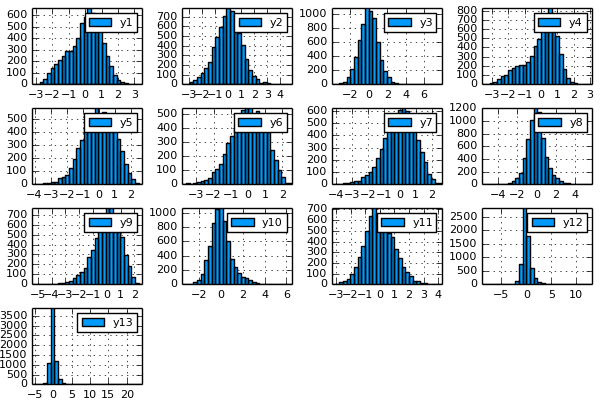

In [33]:
Y = convert(Matrix{Float64}, cg10k_trait[:, 3:15])
histogram(Y, layout = 13)

## Pre-processing data for heritability analysis

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The two variance components are $(2\Phi, I)$.

In [15]:
using VarianceComponentModels

# form data as VarianceComponentVariate
cg10kdata = VarianceComponentVariate(Y, (2Φgrm, eye(size(Y, 1))))
fieldnames(cg10kdata)

3-element Array{Symbol,1}:
 :Y
 :X
 :V

In [16]:
cg10kdata

VarianceComponentModels.VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}}(6670x13 Array{Float64,2}:
 -1.81573   -0.94615     1.11363    …   0.824466  -1.02853     -0.394049 
 -1.2444     0.10966     0.467119       3.08264    1.09065      0.0256616
  1.45567    1.53867     1.09403       -1.10649   -1.42016     -0.687463 
 -0.768809   0.513491    0.244263       0.394175  -0.767366     0.0635386
 -0.264415  -0.34824    -0.0239065      0.549968   0.540688     0.179675 
 -1.37617   -1.47192     0.29118    …   0.947393   0.594015     0.245407 
  0.100942  -0.191616   -0.567421       0.332636   0.00269165   0.317117 
 -0.319818   1.35774     0.81869        0.220861   0.852512    -0.225905 
 -0.288334   0.566083    0.254958       0.167532   0.246916     0.539933 
 -1.1576    -0.781199   -0.595808       0.7331    -1.73468     -1.35278  
  0.740569   1.40874     0.73469    …  -0.712244  -0.313346    -0.345419 
 -0.675892   0.279893    0.267916      -0.809014 

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [17]:
# pre-compute eigen-decomposition (~50 secs on my laptop)
@time cg10kdata_rotated = TwoVarCompVariateRotate(cg10kdata)
fieldnames(cg10kdata_rotated)

 51.720565 seconds (2.08 M allocations: 1.088 GB, 0.33% gc time)


4-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :logdetV2

## Save intermediate results

We don't want to re-compute SnpArray and empirical kinship matrices again and again for heritibility analysis.

In [18]:
using JLD
@save "cg10k.jld"
whos()

                 #174#wsession    280 bytes  JLD.JldWriteSession
                    ArrayViews    186 KB     Module
                          Base  32155 KB     Module
                         Blosc     37 KB     Module
                    ColorTypes    309 KB     Module
                        Colors    743 KB     Module
                        Compat    300 KB     Module
                          Core   6278 KB     Module
                    DataArrays    762 KB     Module
                    DataFrames   1799 KB     Module
                        Docile    415 KB     Module


                        FileIO    536 KB     Module
             FixedPointNumbers     33 KB     Module
               FixedSizeArrays    157 KB     Module
                            GR    418 KB     Module
                          GZip    729 KB     Module
                          HDF5   2903 KB     Module
                        IJulia 2082272 KB     Module
                IPythonDisplay     33 KB     Module
                         Ipopt     26 KB     Module
              IterativeSolvers    486 KB     Module
                           JLD   1168 KB     Module
                          JSON    238 KB     Module
                        KNITRO    273 KB     Module
                          Main 2129896 KB     Module
                  MathProgBase    305 KB     Module
                      Measures     15 KB     Module
                        Nettle     58 KB     Module
                         Plots   2996 KB     Module
                   RecipesBase    193 KB     Module
          

To load workspace

In [19]:
#using SnpArrays, JLD, DataFrames, VarianceComponentModels, Plots
#gr()
#@load "cg10k.jld"
#whos()

## Heritability of single traits

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [20]:
# heritability from single trait analysis
hST = zeros(13)
# standard errors of estimated heritability
hST_se = zeros(13)
# additive genetic effects
σ2a = zeros(13)
# enviromental effects
σ2e = zeros(13)

@time for trait in 1:13
    println(names(cg10k_trait)[trait + 2])
    # form data set for trait j
    traitj_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, trait], cg10kdata_rotated.Xrot, 
        cg10kdata_rotated.eigval, cg10kdata_rotated.logdetV2)
    # initialize model parameters
    traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
    _, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Knitro, verbose=false)
    σ2a[trait] = traitj_model.Σ[1][1]
    σ2e[trait] = traitj_model.Σ[2][1]
    @show σ2a[trait], σ2e[trait]
    # estimate heritability from variance component estimates
    h, hse = heritability(traitj_model.Σ, Σcov)
    hST[trait] = h[1]
    hST_se[trait] = hse[1]
end

Trait1
(σ2a[trait],σ2e[trait]) = (0.26104124348440755,0.7356884322639254)
Trait2

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.



(σ2a[trait],σ2e[trait]) = (0.18874160445323745,0.8106898711546248)
Trait3
(σ2a[trait],σ2e[trait]) = (0.3185719312493428,0.6801458828228928)
Trait4
(σ2a[trait],σ2e[trait]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(0.2655690169564828,0.7303588329793722)
Trait5
(σ2a[trait],σ2e[trait]) = (0.2812332027554256,0.7167989136273715)
Trait6
(σ2a[trait],σ2e[trait]) = (0.2829461142656695,0.7165629541234602)
Trait7


### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(σ2a[trait],σ2e[trait]) = (0.21543858712619832,0.7816210896082411)
Trait8
(σ2a[trait],σ2e[trait]) = (0.19412650095403572,0.8055277516545528)
Trait9
(σ2a[trait],σ2e[trait]) = (0.24789564776328765,0.7504615498312772)
Trait10
(σ2a[trait],σ2e[trait]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(0.10007477232220031,0.899815065485569)
Trait11
(σ2a[trait],σ2e[trait]) = (0.16486781336076242,0.8338001946268285)
Trait12
(σ2a[trait],σ2e[trait]) = (0.08298664768479203,0.9158035237004806)
Trait13


### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.
### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(σ2a[trait],σ2e[trait]) = (0.05684288134841978,0.9423649400242537)
  9.006014 seconds (42.65 M allocations: 1.567 GB, 5.33% gc time)


### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


In [21]:
# heritability and standard errors
[hST'; hST_se']

2x13 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Pairwise traits

Following code snippet calculates joint heritability among all pairs of traits, a total of 78 bivariate variane component models.

In [22]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(13, 13)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(13, 13)

@time for i in 1:13
    for j in (i+1):13
        println(names(cg10k_trait)[i + 2], names(cg10k_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, [i;j]], cg10kdata_rotated.Xrot, 
            cg10kdata_rotated.eigval, cg10kdata_rotated.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Knitro, verbose=false)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
    end
end

Trait1Trait2
(Σa[i,j],Σe[i,j]) = (
[0.26011963304283375 0.17621604357540568
 0.17621604357540568 0.18737645908626693],

[0.7365892246370982 0.5838918930764302
 0.5838918930764302 0.8120328544236115])
Trait1Trait3
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2615639935926043 -0.013126817780806687
 -0.013126817780806687 0.31905662257099676],

[0.7351802111260339 -0.12112674792806083
 -0.12112674792806083 0.6796789899029536])
Trait1Trait4
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26087960318142545 0.22261440535049437
 0.22261440535049437 0.2655808327658264],

[0.7358459981431581 0.5994353346471929
 0.5994353346471929 0.7303474474454599])
Trait1Trait5
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2607830377228068 -0.14701178350992983
 -0.14701178350992983 0.28187724547231285],

[0.7359373011101179 -0.25458389024222405
 -0.25458389024222405 0.7161761241953518])
Trait1Trait6
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2607070355454813 -0.1293564254318824
 -0.1293564254318824 0.28318838487244086],

[0.7360128806953716 -0.23136128305017975
 -0.23136128305017975 0.7163294323340897])
Trait1Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2603075007680198 -0.1402575369593969
 -0.1402575369593969 0.21508055627246248],

[0.7364055998580001 -0.1978054756062745
 -0.1978054756062745 0.7819851899006234])
Trait1Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26103459993881684 -0.033529628076655923
 -0.033529628076655923 0.19414307318689195],

[0.7356949686801786 -0.1262724629104254
 -0.1262724629104254 0.8055115370349195])
Trait1Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26301631603293024 -0.20486492721755545
 -0.20486492721755545 0.24679565240202422],

[0.7337944622763275 -0.3074501359251481
 -0.3074501359251481 0.751544221302954])
Trait1Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26089807914023794 -0.09981756197816269
 -0.09981756197816269 0.09702328558868609],

[0.7358279769051709 -0.3036087585502241
 -0.3036087585502241 0.9028534650390374])
Trait1Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26073970768662846 -0.13898341547609452
 -0.13898341547609452 0.16306263191093168],

[0.7359820027657594 -0.3591745314581464
 -0.3591745314581464 0.8355950431372817])
Trait1Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26306859745591776 -0.14553560783158256
 -0.14553560783158256 0.08051367410937706],

[0.7337809639470937 -0.04169744734666809
 -0.04169744734666809 0.9183593555085752])
Trait1Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26234367617866494 -0.10889551673493038
 -0.10889551673493038 0.05129404082439449],

[0.7344496460809532 -0.11399558362712278
 -0.11399558362712278 0.9479423983042485])
Trait2Trait3
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1890153261775545 0.14615742879577892
 0.14615742879577892 0.3205286589253432],

[0.8104184412055983 0.0974992388766541
 0.0974992388766541 0.6782713240619392])
Trait2Trait4
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1883951500238723 0.07521464672640094
 0.07521464672640094 0.26555848044262403],

[0.8110301027212591 0.22049483198818998
 0.22049483198818998 0.7303691342305415])
Trait2Trait5
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18871644010852243 -0.011314016390024785
 -0.011314016390024785 0.28124653357655377],

[0.8107145247473815 -0.03701047098458601
 -0.03701047098458601 0.7167859985233375])
Trait2Trait6
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18877375996847504 -0.0031066020966233642
 -0.0031066020966233642 0.283012513335213],

[0.8106583656504635 -0.021182657151037395
 -0.021182657151037395 0.7164985873463736])
Trait2Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1883522258642906 -0.02995792622822827
 -0.02995792622822827 0.21518854258468928],

[0.8110719441199802 -0.001369387701185717
 -0.001369387701185717 0.7818678817134607])
Trait2Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18926168901710103 0.03314229378948515
 0.03314229378948515 0.1946662955477292],

[0.8101822287272444 -0.032600267245790716
 -0.032600267245790716 0.8050045055525019])
Trait2Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.187284895909768 -0.08541458527871937
 -0.08541458527871937 0.24671880363132298],

[0.812133045322519 -0.0808790863548776
 -0.0808790863548776 0.7516171284784882])
Trait2Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18896456297889264 -0.125318803903851
 -0.125318803903851 0.10012137191592302],

[0.8104983819040323 -0.27107102265601285
 -0.27107102265601285 0.8998490679270342])
Trait2Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18776200391458975 -0.11847920214116651
 -0.11847920214116651 0.16627341913644897],

[0.8116528151616883 -0.29554899539802887
 -0.29554899539802887 0.8324372717193945])
Trait2Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1881906353905762 -0.09053833092059305
 -0.09053833092059305 0.08226341443411089],

[0.8112716595870854 0.045422033238736864
 0.045422033238736864 0.9165863316200534])
Trait2Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.18826030592280368 -0.0707041233179024
 -0.0707041233179024 0.054723895113346036],

[0.8112166103421581 0.07379770021108435
 0.07379770021108435 0.944520838794711])
Trait3Trait4
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.3185203954068396 -0.15433893722677408
 -0.15433893722677408 0.2647540990644055],

[0.6801958865778468 -0.3034399514060703
 -0.3034399514060703 0.7311518515321968])
Trait3Trait5
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.3189699778876483 0.18435446667875174
 0.18435446667875174 0.28250017725661636],

[0.6797599597754456 0.33641052403301824
 0.33641052403301824 0.715566541213186])
Trait3Trait6
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.319566364443696 0.16663988766209412
 0.16663988766209412 0.285031318252517],

[0.6791832508144324 0.29769765901207323
 0.29769765901207323 0.7145358499800548])
Trait3Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.31857550516039773 0.16685216001949288
 0.16685216001949288 0.215232242283639],

[0.6801424314730239 0.3471388416381536
 0.3471388416381536 0.7818231309736261])
Trait3Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.32049923488933324 0.05753194040336031
 0.05753194040336031 0.19724489863066053],

[0.678283049732137 0.044259740591998324
 0.044259740591998324 0.8024737831816217])
Trait3Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.3187191200344106 0.13729240544494636
 0.13729240544494636 0.24697586634588603],

[0.6800039145396073 0.2671054368269566
 0.2671054368269566 0.7513573840619714])
Trait3Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.31891521326635786 -0.07863382354126468
 -0.07863382354126468 0.10110317208096004],

[0.6798145588403051 -0.14078871560243086
 -0.14078871560243086 0.8987982711681577])
Trait3Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.31782233049899317 -0.01798395920707527
 -0.01798395920707527 0.1647429212236918],

[0.6808712744431354 -0.11416573006758686
 -0.11416573006758686 0.8339228728455864])
Trait3Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.32088834022932194 0.08452483763216109
 0.08452483763216109 0.08698675056812567],

[0.6779139476759036 0.03401327097059086
 0.03401327097059086 0.9118411340081457])
Trait3Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.3230087933900049 0.11068106825381654
 0.11068106825381654 0.06117390024254035],

[0.6759011384609462 -0.007296624823486736
 -0.007296624823486736 0.9380722541843709])
Trait4Trait5
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2656669903887928 -0.21584756082891587
 -0.21584756082891587 0.2829186620451867],

[0.7302544029976884 -0.37667528226319946
 -0.37667528226319946 0.7151643526734748])
Trait4Trait6
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26614305302287716 -0.20063378201233026
 -0.20063378201233026 0.2844419499990165],

[0.7297943215223622 -0.34680407224562393
 -0.34680407224562393 0.7151119490021047])
Trait4Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26448980295469426 -0.1827515734787869
 -0.1827515734787869 0.21411680027043642],

[0.731414561004104 -0.32617199474438135
 -0.32617199474438135 0.782935127963782])
Trait4Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2666939542567245 -0.09763540116013943
 -0.09763540116013943 0.19612608725217262],

[0.729265595547523 -0.15036048122236592
 -0.15036048122236592 0.8035709853505499])
Trait4Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.27003652029243713 -0.22740698735288134
 -0.22740698735288134 0.24804582222345972],

[0.726024514069769 -0.41560143510262837
 -0.41560143510262837 0.7502976666853571])
Trait4Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2655429418578524 -0.03381072172395571
 -0.03381072172395571 0.09960982641894278],

[0.7303952879390396 -0.22772489924348696
 -0.22772489924348696 0.9002752447209031])
Trait4Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.265627602209241 -0.09674003334432629
 -0.09674003334432629 0.16327409089317543],

[0.7303019079374204 -0.27261119458851935
 -0.27261119458851935 0.835371302486883])
Trait4Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2681636974701624 -0.14161260971291825
 -0.14161260971291825 0.08039678155681595],

[0.7278825924021209 -0.08284654892898773
 -0.08284654892898773 0.9184455528644411])
Trait4Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.26617123214390015 -0.09807308743230522
 -0.09807308743230522 0.05401019275561604],

[0.7297749331861804 -0.2250595068988745
 -0.2250595068988745 0.9452044734719449])
Trait5Trait6
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2815916532977782 0.2808983722482332
 0.2808983722482332 0.28229805087804694],

[0.7164553605785435 0.6603676494117775
 0.6603676494117775 0.7171950640737942])
Trait5Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28081437391181985 0.2320998689275443
 0.2320998689275443 0.21166204277253267],

[0.7172180316987311 0.6743038171520931
 0.6743038171520931 0.7853426270875262])
Trait5Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2813401217883996 0.16394787430302493
 0.16394787430302493 0.19270331045507372],

[0.7167009108967377 0.22103210831219622
 0.22103210831219622 0.8069220955922617])
Trait5Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28387780249375544 0.24453172569735382
 0.24453172569735382 0.24129303733683355],

[0.714244139530352 0.508416986759595
 0.508416986759595 0.756894233842363])
Trait5Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.281813015014553 -0.046211414776559816
 -0.046211414776559816 0.10148069070819603],

[0.7162383352292252 -0.057211133587121626
 -0.057211133587121626 0.8984242886885334])
Trait5Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28042354203591974 0.02024954551812159
 0.02024954551812159 0.16400332032759848],

[0.717585625803026 -0.03524364629505358
 -0.03524364629505358 0.8346493307523533])
Trait5Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2814270698032225 0.0616130662533266
 0.0616130662533266 0.08271662820290356],

[0.7166145561475998 0.05292864417364762
 0.05292864417364762 0.9160739284407252])
Trait5Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2822915337284172 0.0704220517748791
 0.0704220517748791 0.0569463103623009],

[0.7157823114204954 0.0528374442279753
 0.0528374442279753 0.9422684288663722])
Trait6Trait7
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28296107606783405 0.22065632109231373
 0.22065632109231373 0.21385609771748512],

[0.7165486719391057 0.5810829179757555
 0.5810829179757555 0.7831785715566137])
Trait6Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2829606227483826 0.18407962650938628
 0.18407962650938628 0.19237902252353256],

[0.716549113331368 0.4365973886384337
 0.4365973886384337 0.8072460050703498])
Trait6Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28497844067329 0.23443573779951848
 0.23443573779951848 0.24320710815424215],

[0.7146005304781758 0.4768263386027498
 0.4768263386027498 0.7550279956930348])
Trait6Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.283654756946724 -0.043548481131816134
 -0.043548481131816134 0.10202532170767714],

[0.7158768650569474 -0.059168124757064296
 -0.059168124757064296 0.8978859539144485])
Trait6Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28152241371209685 0.02799919843008278
 0.02799919843008278 0.16342991317028316],

[0.7179464769366481 -0.052410605978278284
 -0.052410605978278284 0.8352130875249026])
Trait6Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28311434443976785 0.05713989948520504
 0.05713989948520504 0.08267893145260012],

[0.7164030333189758 0.047919870441447195
 0.047919870441447195 0.9161120296671349])
Trait6Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.28381996720739683 0.06112120335535359
 0.06112120335535359 0.05708169009795375],

[0.7157217792290876 0.05326983394180697
 0.05326983394180697 0.9421333541525577])
Trait7Trait8
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.21385686370000928 0.0884555202529293
 0.0884555202529293 0.19237305517789263],

[0.7831777633665213 -0.05683305765915512
 -0.05683305765915512 0.8072518673825659])
Trait7Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2187556960735156 0.21704186386683721
 0.21704186386683721 0.2441438650962115],

[0.7784327750018727 0.46290096789357615
 0.46290096789357615 0.7541229287369133])
Trait7Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2162729625132826 -0.04211457266869773
 -0.04211457266869773 0.10209048405205702],

[0.7808073890597675 -0.08590745174175624
 -0.08590745174175624 0.8978220135332369])
Trait7Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2140687766908337 0.02069668705658004
 0.02069668705658004 0.16347380958930113],

[0.7829608190098053 -0.0481480095351352
 -0.0481480095351352 0.8351704865898298])
Trait7Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.21493232529213507 0.07578743206120728
 0.07578743206120728 0.08087309162565694],

[0.7821316766170044 0.03469555564997924
 0.03469555564997924 0.9179149810048608])
Trait7Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.21595864401353962 0.07493725063727105
 0.07493725063727105 0.05459341673380713],

[0.7811387330531752 0.038905945844645955
 0.038905945844645955 0.9446215680103524])
Trait8Trait9
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1945549994035369 0.11281615599310388
 0.11281615599310388 0.24724415203573846],

[0.8051240569806187 0.1847784334012408
 0.1847784334012408 0.7510982276993537])
Trait8Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.19444100264333258 -0.01563415369373496
 -0.01563415369373496 0.10042647895829539],

[0.8052215712093601 0.011982590593664985
 0.011982590593664985 0.8994678452818253])
Trait8Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.19385316438655778 0.022532462988601197
 0.022532462988601197 0.1646685438687613],

[0.8057962945247207 -0.027274735067597373
 -0.027274735067597373 0.8339969682622954])
Trait8Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1939512185569713 -0.002876012051379462
 -0.002876012051379462 0.08285727490553192],

[0.8056997963051804 0.033612786496067
 0.033612786496067 0.9159318671452499])
Trait8Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1939797616475452 0.004078666732880183
 0.004078666732880183 0.05690712355015743],

[0.8056716011520006 0.037881706240213496
 0.037881706240213496 0.9423010773275475])
Trait9Trait10
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.24729383239070596 -0.002308363032030899
 -0.002308363032030899 0.09982638797189489],

[0.7510505981244205 0.07407294266626882
 0.07407294266626882 0.900061332626126])
Trait9Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2478234437486222 0.03182350311002631
 0.03182350311002631 0.16489046415585396],

[0.7505321390503327 0.15228537745552198
 0.15228537745552198 0.8337779553054802])
Trait9Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.25033469522384055 0.08457136159702837
 0.08457136159702837 0.08875872360922843],

[0.7480909648616011 0.10775632068468866
 0.10775632068468866 0.9101080911475576])
Trait9Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.2494418942472266 0.09348451307851505
 0.09348451307851505 0.0579320154127803],

[0.7489745639634506 0.09821909743478635
 0.09821909743478635 0.9413348850801481])
Trait10Trait11
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.09313967096213309 0.1000337155480984
 0.1000337155480984 0.16495492792203859],

[0.9067034420998209 0.47442666190799393
 0.47442666190799393 0.8337151519152906])
Trait10Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.0967247172271467 0.05640434518849382
 0.05640434518849382 0.07945282806772927],

[0.9031497833428207 0.08532319413612505
 0.08532319413612505 0.9193343424455456])
Trait10Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1009849219848755 -0.02799158673941527
 -0.02799158673941527 0.05783694167619097],

[0.8989368213245361 0.1660507727532715
 0.1660507727532715 0.9413901793900665])
Trait11Trait12
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.1638405774816377 0.05703177998314574
 0.05703177998314574 0.07921436821495581],

[0.834814097199493 0.1455965107997821
 0.1455965107997821 0.9195521320694682])
Trait11Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.16488293344604468 -0.001584137068297981
 -0.001584137068297981 0.05749684397775844],

[0.8337979488216531 0.2006122275637399
 0.2006122275637399 0.9417152318762451])
Trait12Trait13
(Σa[i,j],Σe[i,j]) = 

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


(
[0.08459517870078588 0.06850620319885778
 0.06850620319885778 0.05547715806862392],

[0.9142134906289581 0.5731514384755884
 0.5731514384755884 0.9437337881612475])
 42.315985 seconds (1.91 G allocations: 29.193 GB, 16.54% gc time)


### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


## 5-trait analysis

Researchers want to jointly analyze traits 5-9. Our strategy is to try both Fisher scoring and MM algorithm with different starting point, and choose the best local optimum. We first form the data set and run Fisher scoring, which yields a final objective value 8.68368980794010e+03.

In [23]:
traitidx = 5:9
# form data set
trait59_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, traitidx], cg10kdata_rotated.Xrot, 
    cg10kdata_rotated.eigval, cg10kdata_rotated.logdetV2)
# initialize model parameters
trait59_model = VarianceComponentModel(trait59_data)
# estimate variance components
@time mle_fs!(trait59_model, trait59_data; solver=:Knitro, verbose=true)
trait59_model


Knitro 10.1.0 STUDENT LICENSE (problem size limit = 300)

            Student License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 10.1.0

Knitro presolve eliminated 0 variables and 0 constraints.

algorithm:            1
The problem is identified as bound constrained only.
Knitro changing bar_initpt from AUTO to 3.
Knitro changing bar_murule from AUTO to 4.
Knitro changing bar_penaltycons from AUTO to 1.
Knitro changing bar_penaltyrule from AUTO to 2.
Knitro changing bar_switchrule from AUTO to 1.
Knitro changing linsolver from AUTO to 2.

Problem Characteristics                    ( Presolved)
-----------------------
Objective goal:  Maximize
Number of variables:                    30 (        30)
    bounded below:                      10 (        10)
    bounded above:                       0 (         0)
    bounded below and above:             0 (         0)
    fixed:                               0 (         0)
    free:                               20 (        20)

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(0x5 Array{Float64,2},(
5x5 Array{Float64,2}:
 0.31512   0.319157  0.250341  0.204466  0.24944 
 0.319157  0.329653  0.241834  0.233293  0.247452
 0.250341  0.241834  0.221271  0.113265  0.208544
 0.204466  0.233293  0.113265  0.241484  0.139501
 0.24944   0.247452  0.208544  0.139501  0.376927,

5x5 Array{Float64,2}:
 0.688825  0.632998   0.657586    0.196702   0.528705
 0.632998  0.685078   0.56295     0.408814   0.507746
 0.657586  0.56295    0.775116   -0.0757512  0.501867
 0.196702  0.408814  -0.0757512   0.78627    0.191494
 0.528705  0.507746   0.501867    0.191494   0.756279))

We then run the MM algorithm, starting from the Fisher scoring answer. MM finds an improved solution with objective value 8.955397e+03.

In [24]:
# trait59_model contains the fitted model by Fisher scoring now
@time mle_mm!(trait59_model, trait59_data; verbose=true)
trait59_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0   8.683690e+03
       1   8.749335e+03
       2   8.769373e+03
       3   8.775609e+03
       4   8.777713e+03
       5   8.778568e+03
       6   8.779034e+03
       7   8.779373e+03
       8   8.779666e+03
       9   8.779940e+03
      10   8.780204e+03
      20   8.782575e+03
      30   8.784706e+03
      40   8.786833e+03
      50   8.789198e+03
      60   8.792077e+03
      70   8.795815e+03
      80   8.800822e+03
      90   8.807545e+03
     100   8.816372e+03
     110   8.827478e+03
     120   8.840646e+03
     130   8.855183e+03
     140   8.870054e+03
     150   8.884191e+03
     160   8.896801e+03
     170   8.907505e+03
     180   8.916279e+03
     190   8.923318e+03
     200   8.928908e+03
     210   8.933336e+03
     220   8.936854e+03
     230   8.939668e+03
     240   8.941938e+03
     250   8.943788e+03
     260   8.945309e+03
     270   8.946573e+03
     280   8.947632e+03
     290   8.948528e+

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(0x5 Array{Float64,2},(
5x5 Array{Float64,2}:
 0.261514  0.273061  0.22074    0.167275   0.216444
 0.273061  0.290848  0.219592   0.198638   0.218758
 0.22074   0.219592  0.207146   0.0954691  0.19478 
 0.167275  0.198638  0.0954691  0.207501   0.110312
 0.216444  0.218758  0.19478    0.110312   0.216043,

5x5 Array{Float64,2}:
 0.735836  0.667979   0.685261    0.21787    0.535609
 0.667979  0.708913   0.582131    0.42248    0.492028
 0.685261  0.582131   0.789681   -0.0636001  0.484483
 0.21787   0.42248   -0.0636001   0.792537   0.187238
 0.535609  0.492028   0.484483    0.187238   0.781172))

Do another run of MM algorithm from default starting point. It leads to a slightly better local optimum 8.957172e+03. Follow up anlaysis should use this result.

In [25]:
# default starting point
trait59_model = VarianceComponentModel(trait59_data)
@time _, _, _, Σcov, = mle_mm!(trait59_model, trait59_data; verbose=true)
trait59_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -5.042149e+04
       1  -1.699687e+04
       2  -1.543968e+03
       3   5.143609e+03
       4   7.669359e+03
       5   8.489390e+03
       6   8.728893e+03
       7   8.796019e+03
       8   8.815880e+03
       9   8.823279e+03
      10   8.827419e+03
      20   8.854389e+03
      30   8.874943e+03
      40   8.890795e+03
      50   8.903062e+03
      60   8.912619e+03
      70   8.920130e+03
      80   8.926088e+03
      90   8.930861e+03
     100   8.934721e+03
     110   8.937872e+03
     120   8.940467e+03
     130   8.942622e+03
     140   8.944425e+03
     150   8.945946e+03
     160   8.947237e+03
     170   8.948339e+03
     180   8.949287e+03
     190   8.950106e+03
     200   8.950818e+03
     210   8.951439e+03
     220   8.951983e+03
     230   8.952462e+03
     240   8.952886e+03
     250   8.953262e+03
     260   8.953597e+03
     270   8.953896e+03
     280   8.954164e+03
     290   8.954404e+

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(0x5 Array{Float64,2},(
5x5 Array{Float64,2}:
 0.28408   0.282346  0.235651   0.163231   0.243528
 0.282346  0.287797  0.222888   0.189209   0.231229
 0.235651  0.222888  0.215833   0.0895747  0.212778
 0.163231  0.189209  0.0895747  0.199473   0.107541
 0.243528  0.231229  0.212778   0.107541   0.246379,

5x5 Array{Float64,2}:
 0.714039  0.65898    0.67085     0.221737   0.509435
 0.65898   0.711746   0.578905    0.431453   0.480001
 0.67085   0.578905   0.781276   -0.0579601  0.467102
 0.221737  0.431453  -0.0579601   0.800138   0.189943
 0.509435  0.480001   0.467102    0.189943   0.751844))

Heritability from 5-variate estimate and their standard errors.

In [26]:
h, hse = heritability(trait59_model.Σ, Σcov)
[h'; hse']

2x5 Array{Float64,2}:
 0.284615   0.287928   0.216459   0.199551  0.246817 
 0.0773858  0.0769331  0.0836844  0.085051  0.0809202

## 13-trait analysis

Researchers would like to jointly analyze all 13 traits. Fisher scoring algorithm (with KNITRO backend) ends with objective value of -6.839422e+04.

In [27]:
# initialize model parameters
alltrait_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components
@time mle_fs!(alltrait_model, cg10kdata_rotated; solver=:Knitro, verbose=true)
alltrait_model


Knitro 10.1.0 STUDENT LICENSE (problem size limit = 300)

            Student License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 10.1.0

Knitro presolve eliminated 0 variables and 0 constraints.

algorithm:            1
The problem is identified as bound constrained only.
Knitro changing bar_initpt from AUTO to 3.
Knitro changing bar_murule from AUTO to 4.
Knitro changing bar_penaltycons from AUTO to 1.
Knitro changing bar_penaltyrule from AUTO to 2.
Knitro changing bar_switchrule from AUTO to 1.
Knitro changing linsolver from AUTO to 2.

Problem Characteristics                    ( Presolved)
-----------------------
Objective goal:  Maximize
Number of variables:                   182 (       182)
    bounded below:                      26 (        26)
    bounded above:                       0 (         0)
    bounded below and above:             0 (         0)
    fixed:                               0 (         0)
    free:                              156 (       156)

### Could not find a valid license.
    Your machine ID is e2-9d-cc-64-5f.
    Please contact licensing@artelys.com or your local distributor to obtain a license.
    If you already have a license, please execute `get_machine_ID -v` and send the output to support.


VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(0x13 Array{Float64,2},(
13x13 Array{Float64,2}:
  0.314331    0.132105     -0.0353743   …  -0.136065    -0.105679  
  0.132105    0.139835      0.140532       -0.0173756   -0.00454843
 -0.0353743   0.140532      0.356882        0.0759456    0.0921647 
  0.343477    0.054447     -0.20584        -0.178914    -0.150596  
 -0.129413    0.0162518     0.189194        0.074017     0.0695955 
 -0.113535    0.00983593    0.160915    …   0.0670008    0.0576629 
 -0.103928    0.012809      0.16756         0.0753421    0.0715201 
 -0.0549071   0.000400283   0.0502762       0.00854523   0.00326281
 -0.205264   -0.0387588     0.153961        0.0858418    0.0789957 
 -0.147011   -0.0856788    -0.064831        0.12759      0.0730245 
 -0.155356   -0.0717934    -0.00878633  …   0.0945906    0.0510817 
 -0.136065   -0.0173756     0.0759456       0.357044     0.236415  
 -0.105679   -0.00454843    0.0921647       

Re-run using MM algorithm, which locates a better mode with objective value -4.435632e+04. Follow up anlaysis should use this result.

In [28]:
# initialize model parameters
alltrait_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components
@time _, _, _, Σcov, = mle_mm!(alltrait_model, cg10kdata_rotated; verbose=true)
alltrait_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.311337e+05
       1  -8.002195e+04
       2  -5.807051e+04
       3  -4.926234e+04
       4  -4.611182e+04
       5  -4.511727e+04
       6  -4.482798e+04
       7  -4.474410e+04
       8  -4.471610e+04
       9  -4.470285e+04
      10  -4.469355e+04
      20  -4.462331e+04
      30  -4.456960e+04
      40  -4.452834e+04
      50  -4.449652e+04
      60  -4.447178e+04
      70  -4.445237e+04
      80  -4.443699e+04
      90  -4.442467e+04
     100  -4.441470e+04
     110  -4.440656e+04
     120  -4.439985e+04
     130  -4.439427e+04
     140  -4.438959e+04
     150  -4.438564e+04
     160  -4.438229e+04
     170  -4.437941e+04
     180  -4.437694e+04
     190  -4.437480e+04
     200  -4.437294e+04
     210  -4.437131e+04
     220  -4.436989e+04
     230  -4.436863e+04
     240  -4.436751e+04
     250  -4.436652e+04
     260  -4.436564e+04
     270  -4.436485e+04
     280  -4.436414e+04
     290  -4.436351e+

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(0x13 Array{Float64,2},(
13x13 Array{Float64,2}:
  0.273498    0.192141    -0.0207392   0.231615   …  -0.128643   -0.098307  
  0.192141    0.219573     0.134389    0.0800317     -0.0687355  -0.0433724 
 -0.0207392   0.134389     0.329149   -0.158086       0.0717258   0.097381  
  0.231615    0.0800317   -0.158086    0.277921      -0.129316   -0.104571  
 -0.149294   -0.0130248    0.186275   -0.219746       0.0673901   0.0798606 
 -0.131878   -0.00396265   0.169037   -0.204038   …   0.0539454   0.0662375 
 -0.14514    -0.0332988    0.168384   -0.190066       0.0778299   0.0867255 
 -0.0299641   0.0372326    0.0617453  -0.0918129     -0.0120473  -0.00309877
 -0.205216   -0.0839698    0.137149   -0.232933       0.0895106   0.0971193 
 -0.100475   -0.114933    -0.088079   -0.0435633      0.046928   -0.0048387 
 -0.133733   -0.109897    -0.0247458  -0.0985453  …   0.0587572   0.0114353 
 -0.128643   

Heritability estimate from 13-variate analysis.

In [29]:
h, hse = heritability(alltrait_model.Σ, Σcov)
[h'; hse']

2x13 Array{Float64,2}:
 0.274338   0.219669   0.329511  0.279019   …  0.172946  0.117315   0.10642  
 0.0778364  0.0818365  0.072716  0.0775316     0.087259  0.0902115  0.0903969

## Save analysis results

In [30]:
@save "copd.jld"
whos()

                 #174#wsession    280 bytes  JLD.JldWriteSession
                 #206#wsession    280 bytes  JLD.JldWriteSession
                    ArrayViews    194 KB     Module
                          Base  36817 KB     Module
                         Blosc     37 KB     Module
                    ColorTypes    318 KB     Module
                        Colors    751 KB     Module
                        Compat    327 KB     Module
                          Core   6549 KB     Module
                    DataArrays    762 KB     Module
                    DataFrames   1801 KB     Module
                        Docile    415 KB     Module
                        FileIO    536 KB     Module
             FixedPointNumbers     33 KB     Module
               FixedSizeArrays    157 KB     Module
                            GR    418 KB     Module
                          GZip    758 KB     Module
                          HDF5   3113 KB     Module
                        IJulia 2082289